In [187]:
import re, pytesseract
import spacy, csv, mimetypes
nlp = spacy.load("en_core_web_sm")

In [325]:
import openai
import camelot        # pip install "camelot-py[cv]"
import pdfplumber     # you already use this elsewhere


In [189]:
import os
from dotenv import load_dotenv
load_dotenv()                           # expects .env in the repo root

OPENAI_API_KEY  = os.getenv("OPENAI_API_KEY")
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
PINECONE_ENV     = os.getenv("PINECONE_ENV")  # e.g. "gcp-starter"

In [190]:
import os, base64
from pathlib import Path
from tqdm import tqdm

import fitz                         # PyMuPDF 2.0+
import tabula                       # needs Java;  pip install tabula-py jpype1
from langchain.text_splitter import RecursiveCharacterTextSplitter


In [ ]:
pip install pdfplumber jpype1 tabula-py pillow

In [485]:
from pathlib import Path
import os, base64, json, fitz, pdfplumber
from tqdm import tqdm
import tabula
from langchain.text_splitter import RecursiveCharacterTextSplitter

# ---------- CONFIG ----------
PDF_PATH  = Path("/Users/rajeev/Downloads/doc2.pdf")
BASE_DIR  = Path("data")
DIAGRAM_THRESHOLD = 0.60   # % of page area to be considered full-page diagram
LOGO_THRESHOLD    = 0.10   # % of page area under which we skip as logo/ornament
TEXT_EMPTY_LIMIT   = 100   # page is “empty” if ≤ 100 chars
NEIGHBOR_MIN_CHARS = 200   # char count to decide page is "mostly image"
PIXMAP_ZOOM       = 3      # render factor for full page images
# ----------------------------


In [486]:
# ── page-number helpers ───────────────────────────────────────────────
def pdf_page_no(zero_based: int) -> int:
    """Human page number shown on the PDF (starts at 1)."""
    return zero_based + 1

def page_no_str(zero_based: int) -> str:
    """Formatted page label you can embed in filenames, e.g. 0 → 'p001'."""
    return f"p{zero_based + 1:03d}"
# ---------------------------------------------------------------------


In [487]:
# 1 · utils ------------------------------------------------------
def ensure_dirs():
    for sub in ["images", "text", "tables", "page_images"]:
        (BASE_DIR / sub).mkdir(parents=True, exist_ok=True)

def save_txt(fname: Path, txt: str):
    fname.write_text(txt, encoding="utf-8")

def save_pixmap(pix: fitz.Pixmap, fname: Path):
    if pix.alpha or pix.colorspace.n > 3:
        pix = fitz.Pixmap(fitz.csRGB, pix)
    pix.save(fname)


In [ ]:

# # 2 · caption cache stub ----------------------------------------
# CAPTION_CACHE_FILE = "captions_cache.json"
# if Path(CAPTION_CACHE_FILE).exists():
#     CAPTION_CACHE = json.loads(Path(CAPTION_CACHE_FILE).read_text())
# else:
#     CAPTION_CACHE = {}


In [ ]:
from io import BytesIO
from PIL import Image
import imagehash


def pixmap_to_pil(pix: fitz.Pixmap) -> Image.Image:
    """Convert PyMuPDF pixmap to PIL Image, with fallback for broken samples"""
    try:
        # Convert via bytes safely
        mode = "RGB" if pix.n < 5 else "RGBA"
        img_bytes = pix.tobytes(output="ppm")  # robust fallback
        return Image.open(BytesIO(img_bytes)).convert(mode)
    except Exception as e:
        print(f"[warn] pixmap_to_pil failed: {e}")
        return None


def should_skip_pil_image(pil_img: Image.Image, min_repeat: int = 3) -> bool:
    """Decide whether to skip an image based on perceptual hash frequency"""
    img_hash = str(imagehash.phash(pil_img))
    if img_hash in SKIP_HASHES:
        return True
    HASH_COUNTS[img_hash] = HASH_COUNTS.get(img_hash, 0) + 1
    if HASH_COUNTS[img_hash] >= min_repeat:
        SKIP_HASHES.add(img_hash)
        return True
    return False


In [508]:
def extract_headings(words):
    """Heuristic: return candidate headings by largest font sizes (based on height)."""
    if not words: 
        return []
    # Estimate font size from height
    for w in words:
        w["size"] = round(w["bottom"] - w["top"], 2)

    # Pick largest 2-3 sizes as likely headings
    sizes = sorted({w["size"] for w in words}, reverse=True)[:3]
    headings = [w for w in words if w["size"] in sizes and w["text"].strip()]

    # Group into lines
    result = []
    line = ""
    y_prev = None
    for w in headings:
        if y_prev is None or abs(w["top"] - y_prev) < 2:
            line += " " + w["text"]
        else:
            result.append(line.strip())
            line = w["text"]
        y_prev = w["top"]
    if line.strip(): 
        result.append(line.strip())
    return result


In [ ]:
# # ── add near the top, after `extract_headings` ─────────────────────────
# CAPTION_RE = re.compile(r"Figure\s+\d+\s*[\–\-—]?\s*.*", re.I)
# TABLE_LETTER_RE = re.compile(r"\bTable\s+([A-Z])\b", re.I)

# def group_words_into_lines(words, x_tol=3, y_tol=3):
#     """Tiny helper: merge pdfplumber words into full lines."""
#     lines = []
#     for w in sorted(words, key=lambda w: (round(w["top"],1), w["x0"])):
#         if not lines:
#             lines.append({"text": w["text"], "x0": w["x0"], "y0": w["top"]})
#             continue
#         last = lines[-1]
#         if abs(w["top"] - last["y0"]) <= y_tol:      # same line
#             last["text"] += " " + w["text"]
#         else:
#             lines.append({"text": w["text"], "x0": w["x0"], "y0": w["top"]})
#     return lines

# def nearest_figure_title(img_bbox, caption_lines, max_dist=150):
#     """
#     img_bbox = (x0, y0, x1, y1)
#     caption_lines = list of {"text","x0","y0"}
#     returns best title or ""
#     """
#     ix, iy = ( (img_bbox[0]+img_bbox[2])/2 , (img_bbox[1]+img_bbox[3])/2 )
#     best = None
#     best_d = 9e9
#     for line in caption_lines:
#         if not CAPTION_RE.match(line["text"]): 
#             continue
#         dx = abs(ix - line["x0"])
#         dy = abs(iy - line["y0"])
#         d  = (dx**2 + dy**2)**0.5          # Euclidean
#         if d < best_d and d <= max_dist:
#             best, best_d = line["text"], d
#     return best or ""


In [ ]:
# def merge_multiline_captions(lines, y_tolerance=20):
#     merged = []
#     skip = set()
#     for i, line in enumerate(lines):
#         if i in skip or not CAPTION_RE.match(line["text"]):
#             merged.append(line)
#             continue
#         # Try to merge next line if it's close by vertically
#         for j in range(i+1, len(lines)):
#             if abs(lines[j]["y0"] - line["y0"]) <= y_tolerance:
#                 line["text"] += " " + lines[j]["text"]
#                 skip.add(j)
#             else:
#                 break
#         merged.append(line)
#     return merged


In [160]:
from pinecone import Pinecone

In [489]:
WARNING_TAGS = ("WARNING", "CAUTION", "DANGER", "NOTE", "STEP")
def tag_special_chunks(txt:str)->str:
    for tag in WARNING_TAGS:
        if txt.upper().startswith(tag):
            return f"[{tag}] {txt}"
    return txt

In [ ]:
# from typing import Dict

# SECTION_RE = re.compile(
#     r"^\s*((\d+(\.\d+)*)(\.|\))?\s+)?([A-Z][A-Z\s\-:]{3,})$",
#     re.IGNORECASE
# )


# from typing import Dict
# from collections import defaultdict
# from pathlib import Path
# from pdfminer.high_level import extract_pages
# from pdfminer.layout import LTTextContainer, LTChar

# SECTION_RE = re.compile(
#     r"^\s*((\d+(\.\d+)*)(\.|\))?\s+)?([A-Z][A-Z\s\-:]{3,})$",
#     re.IGNORECASE
# )

# def extract_section_headers(pdf_path: Path, min_font_size: float = 14.0, max_lines_per_page: int = 5) -> Dict[int, list]:
#     headers_by_page = defaultdict(list)

#     for page_num, page_layout in enumerate(extract_pages(pdf_path)):
#         candidate_lines = []

#         for element in page_layout:
#             if isinstance(element, LTTextContainer):
#                 for text_line in element:
#                     line_text = text_line.get_text().strip()
#                     font_sizes = [char.size for char in text_line if isinstance(char, LTChar)]
#                     fonts = [char.fontname for char in text_line if isinstance(char, LTChar)]

#                     if not line_text or not font_sizes:
#                         continue

#                     avg_size = sum(font_sizes) / len(font_sizes)
#                     is_bold = any("Bold" in font for font in fonts)

#                     if avg_size >= min_font_size and is_bold:
#                         y_coord = text_line.bbox[1]  # bottom Y of the line
#                         candidate_lines.append((avg_size, y_coord, line_text))

#         # Sort by size then Y position descending (higher = top of page)
#         candidate_lines.sort(key=lambda tup: (-tup[0], -tup[1]))

#         headers_by_page[page_num] = [
#             {"title": text, "y": y}
#             for _, y, text in candidate_lines[:max_lines_per_page]
#         ]

#     return dict(headers_by_page)


# def is_numbered_heading(text):
#     return bool(re.match(r"^\d+(\.\d+)*", text.strip()))

# def get_section_for_image(
#     image_page: int,
#     image_y: float,
#     section_map: Dict[int, list]
# ) -> str:
#     for pn in reversed(range(0, image_page + 1)):
#         if pn not in section_map:
#             continue

#         # ✅ filter for structured numbered headings only
#         candidates = [
#             h for h in section_map[pn]
#             if is_numbered_heading(h["title"])
#         ]

#         candidates = sorted(candidates, key=lambda h: h.get("y", 0))
#         for sec in reversed(candidates):
#             if pn < image_page or sec.get("y", 0) < image_y:
#                 return sec["title"]
#     return "N/A"


In [490]:
# from pathlib import Path
import base64, mimetypes, uuid, os, time
# from tqdm import tqdm

import openai                     # v1.14+
from langchain_openai import OpenAIEmbeddings
from pinecone import Pinecone, ServerlessSpec

# openai.api_key      = os.getenv("OPENAI_API_KEY")
# PINECONE_API_KEY    = os.getenv("PINECONE_API_KEY")

# ── embedding & chat models (adjust if your account differs) ────────────
EMBED_MODEL = "text-embedding-3-large"    # 1536-D, GPT-4 family
CHAT_MODEL  = "gpt-4o-mini"               # vision-capable

embeddings = OpenAIEmbeddings(model=EMBED_MODEL)

PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")  # keep this

pc = Pinecone(api_key=PINECONE_API_KEY)
index_name = "multimodal-manual"

if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=1536,  # or embeddings.embedding_dimension
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )

index = pc.Index(index_name)


In [ ]:
# # ── helper to build a structured caption block ──────────────────────────
# def make_structured_caption(
#         section_hdr: str,
#         section_body: str,
#         figure_title: str,
#         description: str,
#         page: int,
#         body_chars: int = 280   
# ) -> str:
#     body_clean = re.sub(r"\s+", " ", section_body).strip()[:body_chars]
#     return (
#         f"Section header: {section_hdr or 'N/A'}\n"
#         f"Matter in that section: {body_clean or 'N/A'}\n"
#         f"Figure Title: {figure_title or 'N/A'}\n"
#         f"Description of the image: {description}\n"
#         f"Page no: {page}"
#     )


In [ ]:
def img_to_data_uri(path: Path) -> str:
    mime, _ = mimetypes.guess_type(path)
    b64 = base64.b64encode(path.read_bytes()).decode()
    return f"data:{mime or 'image/png'};base64,{b64}"


# def caption_image(
#     path: Path,
#     heading: str = "",                 # NEW
#     fig_title: str = "",               # NEW
#     snippet: str = "",                 # NEW
#     retry: int = 3
# ) -> str:
#     """Return a single-sentence caption that includes section context."""
#     data_uri = img_to_data_uri(path)

#     for attempt in range(retry):
#         try:
#             resp = openai.chat.completions.create(
#                 model=CHAT_MODEL,
#                 messages=[{
#                     "role": "user",
#                     "content": [
#                         {"type": "text",
#                          "text": build_caption_prompt(heading, fig_title)},
#                         {"type": "image_url", "image_url": {"url": data_uri}},
#                         {"type": "text", "text": snippet[:400]}             # NEW
#                     ]
#                 }],
#                 max_tokens=80                                    # more room
#             )
#             return resp.choices[0].message.content.strip()
#         except openai.RateLimitError:
#             wait = 2 ** attempt
#             print(f"rate-limited, retrying in {wait}s"); time.sleep(wait)

#     return "unavailable caption"

In [ ]:
#Path("captions_cache.json").unlink(missing_ok=True)


In [ ]:
#index.delete(delete_all=True, namespace="v1")


{}

In [ ]:
# # ── DEBUGGING UTILITIES ──────────────────────────────────────────────
# def show_caption_lines(pdf_path: Path, page_idx: int):
#     """Print all lines that look like figure captions on a given page."""
#     with pdfplumber.open(pdf_path) as plumber_pdf:
#         words = plumber_pdf.pages[page_idx].extract_words()
#         lines = group_words_into_lines(words)
#         caps  = [ln for ln in lines if CAPTION_RE.match(ln["text"])]
#         print(f"\n[Page {page_idx}] found {len(caps)} candidate caption lines:")
#         for ln in caps:
#             print(f"  y={ln['y0']:.1f}  {ln['text']}")

# def debug_fig_titles(pdf_path: Path, page_idx: int):
#     """For each image on the page, print the caption selected + distance."""
#     page = fitz.open(pdf_path)[page_idx]
#     page_area = page.rect.width * page.rect.height

#     # collect caption lines once
#     with pdfplumber.open(pdf_path) as pp:
#         caps = group_words_into_lines(pp.pages[page_idx].extract_words())

#     # iterate through images
#     with pdfplumber.open(pdf_path) as pp:
#         for img in pp.pages[page_idx].images:
#             bbox = (img["x0"], img["top"], img["x1"], img["bottom"])
#             title = nearest_figure_title(bbox, caps, max_dist=9999)  # no filter for test
#             # compute distance to that caption
#             if title:
#                 tgt = next(l for l in caps if l["text"] == title)
#                 dx  = abs((bbox[0]+bbox[2])/2 - tgt["x0"])
#                 dy  = abs((bbox[1]+bbox[3])/2 - tgt["y0"])
#                 dist= (dx**2+dy**2)**0.5
#                 pct = (img["width"]*img["height"])/page_area*100
#                 print(f"\n→ Image {img['name']} ({pct:.1f}% of page)")
#                 print(f"   Picked caption : {title}")
#                 print(f"   Distance (px)  : {dist:.1f}")
#             else:
#                 print(f"\n→ Image {img['name']}  —  NO caption found")


In [493]:
# ── put this near the other helpers, ABOVE extract_pdf ──────────────────
import camelot
import warnings
from pathlib import Path

def harvest_tables(pdf_path: Path, page_no: int, **camelot_kw):
    """
    Return a list of Camelot tables (can be empty) extracted from *one* page.
    Silences the noisy 'No tables found' warning and handles None-returns.
    """
    results = []

    # ① try lattice first (good for ruled tables)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        try:
            latt = camelot.read_pdf(
                str(pdf_path),
                pages=str(page_no),
                flavor="lattice",
                **camelot_kw
            )
            results.extend(t for t in latt)     # t is already a Table object
        except Exception as e:
            print(f"[warn] Camelot lattice failed p{page_no}: {e}")

    # ② fallback to stream (good for whitespace-separated tables)
    if not results:                       # only try if lattice found nothing
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            try:
                stre = camelot.read_pdf(
                    str(pdf_path),
                    pages=str(page_no),
                    flavor="stream",
                    **camelot_kw
                )
                results.extend(t for t in stre)
            except Exception as e:
                print(f"[warn] Camelot stream failed p{page_no}: {e}")

    return results


In [494]:
def is_bad_table(rows, min_cols=2, min_rows=3, empty_thresh=0.3):
    if len(rows) < min_rows:
        return True
    num_cols = max(len(r) for r in rows)
    if num_cols < min_cols:
        return True
    total = sum(len(r) for r in rows)
    empty = sum(1 for r in rows for c in r if not c.strip())
    return (empty / total) > empty_thresh


In [495]:
def looks_like_table(text: str, min_rows=3, min_cols=2, col_variance=1):
    lines = [line.strip() for line in text.strip().splitlines() if len(line.strip()) > 10]
    
    if len(lines) < min_rows:
        return False

    col_counts = []

    for line in lines:
        if "|" in line:
            cols = line.split("|")
        elif "\t" in line:
            cols = line.split("\t")
        else:
            cols = re.split(r"\s{2,}", line)

        num_cols = len([c for c in cols if c.strip()])
        if num_cols >= min_cols:
            col_counts.append(num_cols)

    if len(col_counts) < min_rows:
        return False

    # Check for consistent column count (tolerance ±1)
    most_common = max(set(col_counts), key=col_counts.count)
    consistent_rows = sum(abs(nc - most_common) <= col_variance for nc in col_counts)

    return consistent_rows >= min_rows


In [496]:
from PIL import Image

def classify_and_format_tables(ocr_items, model="gpt-4o", max_tokens=1000):
    formatted_items = []
    for item in ocr_items:
        table_text = item["text"]
        path = Path(item["path"])

        classify_prompt = (
            "Does the following text represent a structured table with rows and columns "
            "(e.g., part numbers and descriptions)? Answer only 'Yes' or 'No'.\n\n"
            + table_text
        )

        try:
            classification = openai.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": classify_prompt}],
                temperature=0,
                max_tokens=10
            ).choices[0].message.content.strip().lower()

            if classification == "yes":
                format_prompt = (
                    "Please format the following OCR-extracted text into a structured table "
                    "in markdown format. Infer column headers if not present. "
                    "Fix common OCR issues like broken part numbers or header noise. Part no. do not start with numbers. Ignore numbers in the beginning of part no. as there might be improper OCR extraction."
                    "If possible try to give a name for the table based on any relevant information available, which might be useful while retrieving relevant chunks\n\n"
                    + table_text
                )

                formatted = openai.chat.completions.create(
                    model=model,
                    messages=[{"role": "user", "content": format_prompt}],
                    temperature=0.2,
                    max_tokens=max_tokens
                ).choices[0].message.content.strip()

                formatted_path = path.with_suffix(".formatted.md")
                formatted_path.write_text(formatted, encoding="utf-8")

                formatted_items.append({
                    "page": item["page"],
                    "original_path": str(path),
                    "formatted_path": str(formatted_path),
                    "formatted_text": formatted
                })

                # ✅ delete original noisy OCR .txt
                if path.exists():
                    path.unlink()

            else:
                print(f"❌ Not a table (deleted): {path.name}")
                if path.exists():
                    path.unlink()

        except Exception as e:
            print(f"[!] Error processing table on page {item['page']}: {e}")
            continue

    return formatted_items


In [497]:
############ New Captioning Logic #############

from pathlib import Path          # <-- add (if not already imported)
import hashlib                    # <-- add
import json

caption_cache_file = Path("captions_cache.json")      # make it a Path
try:
    caption_cache: dict[str, str] = json.loads(caption_cache_file.read_text())
except FileNotFoundError:
    caption_cache = {}
except json.JSONDecodeError:          
    print("[warn] captions cache is broken – recreating it")
    caption_cache = {}

def _image_hash(path: Path) -> str:
    """SHA-1 of the *bytes* – fast and collision-safe for our use-case."""
    return hashlib.sha1(path.read_bytes()).hexdigest()

def caption_image_cached(path: Path, **kwargs) -> str:
    """
    Same API as before, but now:
      • key = hash(image_bytes)
      • writes back to captions_cache.json automatically
    """
    key = _image_hash(path)

    # 1) already cached?  → return without hitting the model
    if key in caption_cache:
        return caption_cache[key]

    # 2) otherwise call GPT (your original helper)
    caption = caption_image(path, **kwargs)
    print("Caption:", caption)

    # 3) persist
    caption_cache[key] = caption
    caption_cache_file.write_text(
        json.dumps(caption_cache, indent=2, ensure_ascii=False)
    )
    return caption

In [498]:
#################### image extraction using GPT Begins #########################
def load_text_chunks(text_dir: Path) -> dict:
    pages = defaultdict(list)
    for file in text_dir.glob("doc2_p*_txt*.txt"):
        match = re.search(r"doc2_p(\d+)_txt\d+.txt", file.name)
        if match:
            page = int(match.group(1))
            pages[page].append(file.read_text().strip())
    return pages


In [499]:
def build_context_for_page(pages: dict, page: int, max_back: int = 3) -> str:
    context = []
    for p in reversed(range(max(0, page - max_back), page + 1)):
        context.extend(pages.get(p, []))
    return "\n\n".join(context)


In [500]:
def build_metadata_prompt(image_filename: str, context: str) -> str:
    return f"""
You are analyzing a page from a machine user manual that includes an illustration named {image_filename}.

From the given context, extract the following metadata:

1. Section header: The most recent section heading (e.g., "2.1 Technical Warnings").
2. Figure title: The full label like "Figure 5 – Speed Adjustment Panel", if present.
3. Snippet: A 200–400 character text snippet surrounding the figure title.
4. Purpose: What the figure illustrates and why it matters in the manual (one sentence).

Respond in the following structured format:

Section header: ...
Figure title: ...
Snippet: ...
Purpose: ...
"""


In [501]:
def caption_with_gpt_vision(image_path: Path, context: str) -> dict:
    data_uri = img_to_data_uri(image_path)
    prompt = build_metadata_prompt(image_path.name, context)
    
    response = openai.chat.completions.create(
        model="gpt-4o",
        messages=[{
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {"type": "image_url", "image_url": {"url": data_uri}},
                {"type": "text", "text": context[:4000]}  # safe length
            ]
        }],
        max_tokens=200
    )

    return response.choices[0].message.content.strip()


In [502]:
pages = load_text_chunks(Path("data/text"))


In [480]:
image_files = sorted(Path("data/images").glob("doc2_p*_img*.png"))

for img_path in image_files:
    match = re.search(r"doc2_p(\d+)_img", img_path.name)
    if not match:
        continue

    page = int(match.group(1))
    context = build_context_for_page(pages, page)
    caption = caption_with_gpt_vision(img_path, context)
    
    print(f"\n🖼️ {img_path.name}")
    print(caption)



🖼️ doc2_p001_img00_515.png
I'm sorry, but I can't access the content surrounding the image to provide the detailed metadata you requested.

🖼️ doc2_p001_img01_516.png
I can’t extract text or metadata directly from images. If you provide the surrounding text from the manual, I can help analyze and structure it based on your instructions.

🖼️ doc2_p012_img02_32.png
Sure, here’s the structured metadata based on your request:

**Section header:** 4 DESCRIPTION OF THE MACHINE

**Figure title:** Figure 1 – Typical main groups of the bench lathe

**Snippet:** There are two main groups within the Lathe (see figure 1): The spindle shaft unit; The sliding tool holder unit. The first is constituted by the spindle, which is made integral with the workpiece, and by the components that transmit motion from the motor to the spindle.

**Purpose:** The figure illustrates the main components of the bench lathe, highlighting its structural and functional aspects, which are crucial for understanding its 

In [ ]:
# # 3 · main extractor --------------------------------------------
# # TABLE_LETTER_RE = re.compile(r"(?:TABLE|FIGURE)\s+([A-Z])", re.I)

# def extract_pdf(pdf_path: Path):
#     ensure_dirs()
#     splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=200)

#     items = []
#     doc   = fitz.open(pdf_path)

#     def local_snippet(page_text: str, fig_title: str, span: int = 120) -> str:
#         if not fig_title:
#             return ""
#         idx = page_text.find(fig_title)
#         if idx == -1:
#             return ""
#         start = max(idx - span, 0)
#         end   = idx + len(fig_title) + span
#         return page_text[start:end].replace("\n", " ")

#     for page_idx in tqdm(range(len(doc)), desc="Processing pages"):
#         page = doc[page_idx]
#         caption_lines = []          # <── default so it always exists
#         current_h      = ""         # <── same idea for heading
#         try:
#             with pdfplumber.open(pdf_path) as plumber_pdf:
#                 plumber_page = plumber_pdf.pages[page_idx]
#                 pl_words      = plumber_page.extract_words()
#                 caption_lines = merge_multiline_captions(group_words_into_lines(pl_words))
#                 headings = extract_headings(pl_words)
#                 current_h = headings[0] if headings else ""
#         except Exception as e:
#             print(f"[warn] heading extraction failed on page {page_idx}: {e}")

#         raw_text = page.get_text("text", sort=True).strip()
#         # ---  accurate caption grab  ----------------------------------
#         m_cap = re.search(r"(Table\s+[A-Z][^\n]{0,80})", raw_text, re.I)
#         caption_title = m_cap.group(1).strip() if m_cap else ""

#         if len(raw_text) < 20:            # likely scanned text
#             ocr_img = page.get_pixmap(matrix=fitz.Matrix(2,2))
#             ocr_txt = pytesseract.image_to_string(Image.open(BytesIO(ocr_img.tobytes()))).strip()
#             if len(ocr_txt) > 20:
#                 raw_text = ocr_txt

#         # ---------- NEW: figure title & snippet ----------
#         m = re.search(r"(Figure\s+\d+\s*[\–\-—]\s*[^\n]{5,80})", raw_text)
#         fig_title = m.group(1).strip() if m else ""
#         snippet   = local_snippet(raw_text, fig_title)

#         # ---------- Table extraction (Tabula ➜ Camelot) ----------
#         tables = harvest_tables(pdf_path, page_idx + 1)


#         # Process extracted tables
#         for t_idx, table in enumerate(tables):
#             cleaned_rows = []

#             # Tabula: pandas DataFrame
#             if hasattr(table, "df"):  # Camelot Table object
#                 rows = table.df.values.tolist()
#             elif hasattr(table, "values"):  # Tabula DataFrame
#                 rows = table.values.tolist()
#             else:
#                 rows = table  # pdfplumber: list of lists


#             # Clean: strip whitespace, flatten \n, fill empty with ""
#             for row in rows:
#                 row = [str(cell).strip().replace("\n", " ") if cell else "" for cell in row]
#                 if any(cell for cell in row):  # skip empty rows
#                     cleaned_rows.append(row)

#             # --- Reconstruct multiline rows ---
#             reconstructed_rows = []
#             current_row = None

#             for row in cleaned_rows:
#                 if row[0].strip():  # new row
#                     if current_row:
#                         reconstructed_rows.append(current_row)
#                     current_row = row
#                 else:  # continuation of previous row
#                     if current_row:
#                         for i in range(len(row)):
#                             if row[i].strip():
#                                 current_row[i] += " " + row[i]

#             if current_row:
#                 reconstructed_rows.append(current_row)

#             # OCR fallback if table looks bad
#             if is_bad_table(reconstructed_rows):
#                 print(f"[!] Table {t_idx} on page {page_idx} may be bad — attempting OCR fallback")

#                 pix = page.get_pixmap(matrix=fitz.Matrix(2, 2))
#                 img = Image.open(BytesIO(pix.tobytes()))
#                 ocr_text = pytesseract.image_to_string(img)
#                 # Optional: implement a smarter way to parse tables from OCR here (e.g., layoutparser or custom splitter)

#                 # Save fallback version
#                 page_lbl = page_no_str(page_idx)  # ensure defined
#                 fallback_path = BASE_DIR / "tables" / f"{pdf_path.stem}_{page_lbl}_tbl{t_idx:02d}_ocr.txt"
#                 save_txt(fallback_path, ocr_text)

#                 looks_like = looks_like_table(ocr_text)
#                 if not looks_like:
#                     print(f"⚠️ OCR text on page {page_idx}, table {t_idx} might not be a valid table — saved anyway for review.")

#                 items.append({
#                     "page": pdf_page_no(page_idx),
#                     "page0": page_idx,
#                     "type": "table",
#                     "text": ocr_text,
#                     "path": str(fallback_path),
#                     "section": current_h,
#                     "figure_title": fig_title,
#                     "caption_title": caption_title,
#                     "extracted_with": "ocr",
#                     "ocr_looks_like_table": looks_like  # 🔍 extra metadata for filtering later
#                 })
#                 continue  # skip original bad table

#             caption_title = ""
                    
#             # Convert to clean text for embedding
#             table_text = "\n".join([" | ".join(row) for row in reconstructed_rows])

#             # Save .txt for RAG
#             page_lbl = page_no_str(page_idx)               # NEW
#             f = BASE_DIR / "tables" / f"{pdf_path.stem}_{page_lbl}_tbl{t_idx:02d}.txt"
#             save_txt(f, table_text)

#             # Append to items
#             items.append({
#                 "page": pdf_page_no(page_idx),
#                 "page0": page_idx,
#                 "type": "table",
#                 "text": table_text,
#                 "path": str(f),
#                 "section": current_h,
#                 "figure_title": fig_title,
#                 "caption_title": caption_title
#             })


#         # ---------- Text chunking ----------
#         if raw_text:
#             for i, chunk in enumerate(splitter.split_text(raw_text)):
#                 page_lbl = page_no_str(page_idx)               # NEW
#                 f = BASE_DIR / "text" / f"{pdf_path.stem}_{page_lbl}_txt{i:02d}.txt"
#                 save_txt(f, chunk)
#                 items.append({
#                     "page": pdf_page_no(page_idx),    # 1-based page no
#                     "page0": page_idx,
#                     "type": "text",
#                     "text": chunk,
#                     "section": current_h,           # ▶️  add detected heading
#                     "path": str(f)
#                 })

#         # ---------- Image logic ----------
#         page_bbox = page.rect
#         page_area = page_bbox.width * page_bbox.height
#         full_page_diagram = False

#         with pdfplumber.open(pdf_path) as plumber_pdf:
#             plumber_page = plumber_pdf.pages[page_idx]
#             imgs = plumber_page.images  # gives bbox coords
#             #print(f"[Page {page_idx}] {len(imgs)} images found")
#             for img in imgs:
#                 img_area = img["width"] * img["height"]
#                 #print(f"  → {round(img_area / page_area * 100, 2)}% of page")

#         # Filter out tiny logos
#         large_imgs = [
#             img for img in imgs
#             if (img["width"] * img["height"]) / page_area > LOGO_THRESHOLD
#         ]

#         # Heuristic: one large image covers most of the page
#         composite_area = sum(img["width"] * img["height"] for img in imgs if (img["width"] * img["height"]) / page_area > 0.15)

#         if composite_area / page_area > 0.40:
#             full_page_diagram = True

#         if full_page_diagram:
#             # Render whole page at high res
#             pix = page.get_pixmap(matrix=fitz.Matrix(PIXMAP_ZOOM, PIXMAP_ZOOM))
#             page_lbl = page_no_str(page_idx)               # NEW
#             f = BASE_DIR / "page_images" / f"{pdf_path.stem}_{page_lbl}_diag.png"
#             save_pixmap(pix, f)

#             bbox = (0, 0, page.rect.width, page.rect.height)
#             fig_title = nearest_figure_title(bbox, caption_lines)

#             heading = current_h or ""          # reuse the page heading, fallback to ""

#             description = caption_image_cached(
#                 f,
#                 heading=heading,
#                 fig_title=fig_title,
#                 snippet=snippet
#             )

#             context     = build_context_for_page(pages_dict, page_idx)   # ← 1-3 pages back
#             description = caption_with_gpt_vision(fname, context)
            
#             structured = make_structured_caption(
#                 section_hdr=heading,
#                 section_body=raw_text,
#                 figure_title=fig_title,
#                 description=description,
#                 page=page_idx,
#             )
            
#             # If page text is too short, pull context from neighbors
#             related = ""
#             if len(raw_text) <= TEXT_EMPTY_LIMIT:
#                 for adj_idx in (page_idx - 1, page_idx + 1):
#                     if 0 <= adj_idx < len(doc):
#                         adj_text = doc[adj_idx].get_text("text", sort=True).strip()
#                         if len(adj_text) >= NEIGHBOR_MIN_CHARS:
#                             related += f"\n[[Neighbor page {adj_idx}]]\n" + adj_text


#             items.append({
#                 "page": pdf_page_no(page_idx),    # 1-based page no
#                 "page0": page_idx,
#                 "type": "page",
#                 "path": str(f),
#                 "text": structured,         # 🔑  what gets embedded
#                 "section": current_h,
#                 "figure_title": fig_title,
#                 "structured": structured    # (optional) raw block for later use
#             })

#             #print(f"✅ Detected composite diagram on page {page_idx} covering {round(composite_area / page_area * 100, 2)}%")

#             m = re.search(r"(Figure\s+\d+\s*[\–\-—]\s*[^\n]{5,80})", raw_text)
#             if m:
#                 items[-1]["caption_title"] = m.group(1).strip()

#         else:
#             # Normal inline images
#             page_area = page.rect.width * page.rect.height

#             with pdfplumber.open(pdf_path) as plumber_pdf:
#                 plumber_page = plumber_pdf.pages[page_idx]
#                 imgs = plumber_page.images  # contains width, height, x0, y0, etc.

#             for idx, img in enumerate(page.get_images(full=True)):
#                 xref = img[0]

#                 # 🔍 Find the matching image in plumber by xref (or fallback to estimated area)
#                 matching = next((i for i in imgs if i.get("name") == img[7]), None)

#                 if matching:
#                     img_area = matching["width"] * matching["height"]
#                 else:
#                     pix = fitz.Pixmap(doc, xref)
#                     img_area = pix.width * pix.height

#                 percent = img_area / page_area

#                 if percent < 0.01:
#                     #print(f"🗑️ Skipped small image on page {page_idx}: {round(percent * 100, 2)}% of page")
#                     continue

#                 pix = fitz.Pixmap(doc, xref)
#                 page_lbl = page_no_str(page_idx)               # NEW
#                 fname     = BASE_DIR / "images" / (
#                     f"{pdf_path.stem}_{page_lbl}_img{idx:02d}_{xref}.png"
#                 )

#                 save_pixmap(pix, fname)

#                 if matching:
#                     bbox = (matching["x0"], matching["top"], matching["x1"], matching["bottom"])

#                 else:
#                     bbox = (0, 0, 0, 0)  # fallback

#                 fig_title = nearest_figure_title(bbox, caption_lines)

#                 
# 
#           # reuse the page heading, fallback to ""
                
#                 description = caption_image_cached(
#                     fname,
#                     heading=heading,
#                     fig_title=fig_title,
#                     snippet=snippet
#                 )

#                 structured = make_structured_caption(
#                     section_hdr=heading,
#                     section_body=raw_text,
#                     figure_title=fig_title,
#                     description=description,
#                     page=page_idx,
#                 )

#                 items.append({
#                     "page": pdf_page_no(page_idx),    # 1-based page no
#                     "page0": page_idx,
#                     "type": "image",
#                     "path": str(fname),
#                     "text": structured,         # 🔑
#                     "section": heading,
#                     "figure_title": fig_title,
#                     "structured": structured
#                 })

#                 m = re.search(r"(Figure\s+\d+\s*[\–\-—]\s*[^\n]{5,80})", raw_text)
#                 if m:
#                     items[-1]["caption_title"] = m.group(1).strip()

#     print("\n🧾 Pages with full-page diagrams:")
#     print([item["page"] for item in items if item["type"] == "page"])
    
#     print(f"✅ finished – extracted {len(items)} items")
    
#     # print("🔎 Items with caption_title:", sum(1 for x in items if x.get("caption_title")))
#     return items


In [509]:
METADATA_CACHE_FILE = "image_metadata_cache.json"

import json

if Path(METADATA_CACHE_FILE).exists():
    with open(METADATA_CACHE_FILE, "r", encoding="utf-8") as f:
        metadata_cache = json.load(f)
else:
    metadata_cache = {}


In [ ]:
################# NEW LOGIC ######################
# 3 · main extractor --------------------------------------------
# TABLE_LETTER_RE = re.compile(r"(?:TABLE|FIGURE)\s+([A-Z])", re.I)

def extract_pdf(pdf_path: Path):
    ensure_dirs()
    splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=200)

    items = []
    doc   = fitz.open(pdf_path)

    def local_snippet(page_text: str, fig_title: str, span: int = 120) -> str:
        if not fig_title:
            return ""
        idx = page_text.find(fig_title)
        if idx == -1:
            return ""
        start = max(idx - span, 0)
        end   = idx + len(fig_title) + span
        return page_text[start:end].replace("\n", " ")

    for page_idx in tqdm(range(len(doc)), desc="Processing pages"):
        page = doc[page_idx]
        caption_lines = []          # <── default so it always exists
        current_h      = ""         # <── same idea for heading
        try:
            with pdfplumber.open(pdf_path) as plumber_pdf:
                plumber_page = plumber_pdf.pages[page_idx]
                pl_words      = plumber_page.extract_words()
                #caption_lines = merge_multiline_captions(group_words_into_lines(pl_words))
                headings = extract_headings(pl_words)
                current_h = headings[0] if headings else ""
        except Exception as e:
            print(f"[warn] heading extraction failed on page {page_idx}: {e}")

        raw_text = page.get_text("text", sort=True).strip()
        # ---  accurate caption grab  ----------------------------------
        m_cap = re.search(r"(Table\s+[A-Z][^\n]{0,80})", raw_text, re.I)
        caption_title = m_cap.group(1).strip() if m_cap else ""

        if len(raw_text) < 20:            # likely scanned text
            ocr_img = page.get_pixmap(matrix=fitz.Matrix(2,2))
            ocr_txt = pytesseract.image_to_string(Image.open(BytesIO(ocr_img.tobytes()))).strip()
            if len(ocr_txt) > 20:
                raw_text = ocr_txt

        # ---------- NEW: figure title & snippet ----------
        m = re.search(r"(Figure\s+\d+\s*[\–\-—]\s*[^\n]{5,80})", raw_text)
        fig_title = m.group(1).strip() if m else ""
        #snippet   = local_snippet(raw_text, fig_title)

        # ---------- Table extraction (Tabula ➜ Camelot) ----------
        tables = harvest_tables(pdf_path, page_idx + 1)


        # Process extracted tables
        for t_idx, table in enumerate(tables):
            cleaned_rows = []

            # Tabula: pandas DataFrame
            if hasattr(table, "df"):  # Camelot Table object
                rows = table.df.values.tolist()
            elif hasattr(table, "values"):  # Tabula DataFrame
                rows = table.values.tolist()
            else:
                rows = table  # pdfplumber: list of lists


            # Clean: strip whitespace, flatten \n, fill empty with ""
            for row in rows:
                row = [str(cell).strip().replace("\n", " ") if cell else "" for cell in row]
                if any(cell for cell in row):  # skip empty rows
                    cleaned_rows.append(row)

            # --- Reconstruct multiline rows ---
            reconstructed_rows = []
            current_row = None

            for row in cleaned_rows:
                if row[0].strip():  # new row
                    if current_row:
                        reconstructed_rows.append(current_row)
                    current_row = row
                else:  # continuation of previous row
                    if current_row:
                        for i in range(len(row)):
                            if row[i].strip():
                                current_row[i] += " " + row[i]

            if current_row:
                reconstructed_rows.append(current_row)

            # OCR fallback if table looks bad
            if is_bad_table(reconstructed_rows):
                print(f"[!] Table {t_idx} on page {page_idx} may be bad — attempting OCR fallback")

                pix = page.get_pixmap(matrix=fitz.Matrix(2, 2))
                img = Image.open(BytesIO(pix.tobytes()))
                ocr_text = pytesseract.image_to_string(img)
                # Optional: implement a smarter way to parse tables from OCR here (e.g., layoutparser or custom splitter)

                # Save fallback version
                page_lbl = page_no_str(page_idx)  # ensure defined
                fallback_path = BASE_DIR / "tables" / f"{pdf_path.stem}_{page_lbl}_tbl{t_idx:02d}_ocr.txt"
                save_txt(fallback_path, ocr_text)

                looks_like = looks_like_table(ocr_text)
                if not looks_like:
                    print(f"⚠️ OCR text on page {page_idx}, table {t_idx} might not be a valid table — saved anyway for review.")

                items.append({
                    "page": pdf_page_no(page_idx),
                    "page0": page_idx,
                    "type": "table",
                    "text": ocr_text,
                    "path": str(fallback_path),
                    "section": current_h,
                    "figure_title": fig_title,
                    "caption_title": caption_title,
                    "extracted_with": "ocr",
                    "ocr_looks_like_table": looks_like  # 🔍 extra metadata for filtering later
                })
                continue  # skip original bad table

            caption_title = ""
                    
            # Convert to clean text for embedding
            table_text = "\n".join([" | ".join(row) for row in reconstructed_rows])

            # Save .txt for RAG
            page_lbl = page_no_str(page_idx)               # NEW
            f = BASE_DIR / "tables" / f"{pdf_path.stem}_{page_lbl}_tbl{t_idx:02d}.txt"
            save_txt(f, table_text)

            # Append to items
            items.append({
                "page": pdf_page_no(page_idx),
                "page0": page_idx,
                "type": "table",
                "text": table_text,
                "path": str(f),
                "section": current_h,
                "figure_title": fig_title,
                "caption_title": caption_title
            })


        # ---------- Text chunking ----------
        if raw_text:
            for i, chunk in enumerate(splitter.split_text(raw_text)):
                page_lbl = page_no_str(page_idx)               # NEW
                f = BASE_DIR / "text" / f"{pdf_path.stem}_{page_lbl}_txt{i:02d}.txt"
                save_txt(f, chunk)
                items.append({
                    "page": pdf_page_no(page_idx),    # 1-based page no
                    "page0": page_idx,
                    "type": "text",
                    "text": chunk,
                    "section": current_h,           # ▶️  add detected heading
                    "path": str(f)
                })

        # ---------- Image logic ----------
        page_bbox = page.rect
        page_area = page_bbox.width * page_bbox.height
        full_page_diagram = False

        with pdfplumber.open(pdf_path) as plumber_pdf:
            plumber_page = plumber_pdf.pages[page_idx]
            imgs = plumber_page.images  # gives bbox coords
            #print(f"[Page {page_idx}] {len(imgs)} images found")
            for img in imgs:
                img_area = img["width"] * img["height"]
                #print(f"  → {round(img_area / page_area * 100, 2)}% of page")

        # Filter out tiny logos
        large_imgs = [
            img for img in imgs
            if (img["width"] * img["height"]) / page_area > LOGO_THRESHOLD
        ]

        # Heuristic: one large image covers most of the page
        composite_area = sum(img["width"] * img["height"] for img in imgs if (img["width"] * img["height"]) / page_area > 0.15)

        if composite_area / page_area > 0.40:
            full_page_diagram = True

        if full_page_diagram:
            # Render whole page at high res
            pix = page.get_pixmap(matrix=fitz.Matrix(PIXMAP_ZOOM, PIXMAP_ZOOM))
            page_lbl = page_no_str(page_idx)               # NEW
            f = BASE_DIR / "page_images" / f"{pdf_path.stem}_{page_lbl}_diag.png"
            save_pixmap(pix, f)

            bbox = (0, 0, page.rect.width, page.rect.height)
            #fig_title = nearest_figure_title(bbox, caption_lines)

            heading = current_h or ""          # reuse the page heading, fallback to ""

            description = caption_with_gpt_vision(f, context)
            
            # If page text is too short, pull context from neighbors
            related = ""
            if len(raw_text) <= TEXT_EMPTY_LIMIT:
                for adj_idx in (page_idx - 1, page_idx + 1):
                    if 0 <= adj_idx < len(doc):
                        adj_text = doc[adj_idx].get_text("text", sort=True).strip()
                        if len(adj_text) >= NEIGHBOR_MIN_CHARS:
                            related += f"\n[[Neighbor page {adj_idx}]]\n" + adj_text


            items.append({
                "page": pdf_page_no(page_idx),    # 1-based page no
                "page0": page_idx,
                "type": "page",
                "path": str(f),
                "text": description,         # 🔑  what gets embedded
                "section": current_h
                #"figure_title": fig_title
            })

            #print(f"✅ Detected composite diagram on page {page_idx} covering {round(composite_area / page_area * 100, 2)}%")

            m = re.search(r"(Figure\s+\d+\s*[\–\-—]\s*[^\n]{5,80})", raw_text)
            if m:
                items[-1]["caption_title"] = m.group(1).strip()

        else:
            # Normal inline images
            page_area = page.rect.width * page.rect.height

            with pdfplumber.open(pdf_path) as plumber_pdf:
                plumber_page = plumber_pdf.pages[page_idx]
                imgs = plumber_page.images  # contains width, height, x0, y0, etc.

            for idx, img in enumerate(page.get_images(full=True)):
                xref = img[0]

                # 🔍 Find the matching image in plumber by xref (or fallback to estimated area)
                matching = next((i for i in imgs if i.get("name") == img[7]), None)

                if matching:
                    img_area = matching["width"] * matching["height"]
                else:
                    pix = fitz.Pixmap(doc, xref)
                    img_area = pix.width * pix.height

                percent = img_area / page_area

                if percent < 0.01:
                    #print(f"🗑️ Skipped small image on page {page_idx}: {round(percent * 100, 2)}% of page")
                    continue

                pix = fitz.Pixmap(doc, xref)
                page_lbl = page_no_str(page_idx)               # NEW
                fname     = BASE_DIR / "images" / (
                    f"{pdf_path.stem}_{page_lbl}_img{idx:02d}_{xref}.png"
                )

                save_pixmap(pix, fname)

                if matching:
                    bbox = (matching["x0"], matching["top"], matching["x1"], matching["bottom"])

                else:
                    bbox = (0, 0, 0, 0)  # fallback

                #fig_title = nearest_figure_title(bbox, caption_lines)

                heading = current_h or ""          # reuse the page heading, fallback to ""
                
                description = caption_with_gpt_vision(fname, context)


                items.append({
                    "page": pdf_page_no(page_idx),    # 1-based page no
                    "page0": page_idx,
                    "type": "image",
                    "text": "descrpition",
                    "path": str(fname),       
                    "section": heading
                    #"figure_title": fig_title
                })

                m = re.search(r"(Figure\s+\d+\s*[\–\-—]\s*[^\n]{5,80})", raw_text)
                if m:
                    items[-1]["caption_title"] = m.group(1).strip()

    print("\n🧾 Pages with full-page diagrams:")
    print([item["page"] for item in items if item["type"] == "page"])
    
    print(f"✅ finished – extracted {len(items)} items")
    
    # print("🔎 Items with caption_title:", sum(1 for x in items if x.get("caption_title")))
    return items


In [507]:
import shutil
shutil.rmtree("data/images", ignore_errors=True)
shutil.rmtree("data/page_images", ignore_errors=True)
shutil.rmtree("data/tables", ignore_errors=True)
shutil.rmtree("data/text", ignore_errors=True)


In [504]:

# ---------------- RUN ----------------
items = extract_pdf(PDF_PATH)


Processing pages:   0%|          | 0/84 [00:00<?, ?it/s]

[!] Table 0 on page 0 may be bad — attempting OCR fallback


python(84017) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


⚠️ OCR text on page 0, table 0 might not be a valid table — saved anyway for review.
Caption: [Figure] This figure shows a lathe machine with a digital readout, which is essential for precise measurements and improved accuracy in machining operations.


Processing pages:   1%|          | 1/84 [00:08<11:24,  8.25s/it]

Caption: [Figure] This illustration displays the FERVI logo, which signifies the brand identity and quality assurance of the pro smart equipment used in the machine.
[!] Table 0 on page 1 may be bad — attempting OCR fallback


python(84122) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing pages:   2%|▏         | 2/84 [00:09<06:01,  4.40s/it]

⚠️ OCR text on page 1, table 0 might not be a valid table — saved anyway for review.
[!] Table 0 on page 2 may be bad — attempting OCR fallback


python(84134) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing pages:   4%|▎         | 3/84 [00:12<04:53,  3.62s/it]

⚠️ OCR text on page 2, table 0 might not be a valid table — saved anyway for review.
[!] Table 0 on page 3 may be bad — attempting OCR fallback


python(84136) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing pages:   5%|▍         | 4/84 [00:14<03:59,  3.00s/it]

⚠️ OCR text on page 3, table 0 might not be a valid table — saved anyway for review.


Processing pages:   5%|▍         | 4/84 [00:15<05:07,  3.85s/it]

[!] Table 0 on page 4 may be bad — attempting OCR fallback


KeyboardInterrupt: 

In [430]:
ocr_items = [item for item in items if item.get("extracted_with") == "ocr"]
formatted = classify_and_format_tables(ocr_items)


❌ Not a table (deleted): doc2_p001_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p002_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p003_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p004_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p005_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p006_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p007_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p007_tbl01_ocr.txt
❌ Not a table (deleted): doc2_p008_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p011_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p012_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p013_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p014_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p015_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p016_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p017_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p018_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p019_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p020_tbl00_ocr.txt
❌ Not a table (deleted): doc2_p021_tbl00_ocr.txt
❌ Not a table (delet

In [382]:
from pathlib import Path

# Look inside the regular tables folder
md_paths = list((BASE_DIR / "tables").glob("*.md"))

for md_path in md_paths:
    content = md_path.read_text(encoding="utf-8")
    page_match = re.search(r"p(\d+)", md_path.stem)
    page_num = int(page_match.group(1)) if page_match else -1

    items.append({
        "page": page_num,
        "type": "table",
        "text": content,
        "path": str(md_path),
        "section": "",
        "figure_title": "",
        "caption_title": "",
        "extracted_with": "gpt4-md"
    })

print(f"📄 Loaded {len(md_paths)} markdown tables from 'tables' folder.")


📄 Loaded 9 markdown tables from 'tables' folder.


In [ ]:
# from collections import defaultdict

# # --------- Table grouping post-process logic ---------
# TABLE_LETTER_RE = re.compile(r"Table\s+([A-Z])", re.I)

# # 1. Group tables by detected table letter
# table_groups = defaultdict(list)
# for it in items:
#     if it["type"] == "table":
#         title = it.get("caption_title") or it.get("figure_title") or ""
#         match = TABLE_LETTER_RE.search(title)
#         if match:
#             letter = match.group(1).upper()
#             it["table_letter"] = letter
#             table_groups[letter].append(it)

# # 2. Assign matching table letter to nearby page images (±2 pages)
# for it in items:
#     if it["type"] != "page":
#         continue
#     for letter, tbls in table_groups.items():
#         for tbl in tbls:
#             if abs(tbl["page"] - it["page"]) <= 2:
#                 it["table_letter"] = letter
#                 it["table_ref"] = [t["path"] for t in tbls]
#                 for t in tbls:
#                     t.setdefault("image_ref", []).append(it["path"])
#                 break


In [381]:
from pathlib import Path

md_dir = BASE_DIR / "formatted_tables"
print(f"📂 Looking in: {md_dir.resolve()}")
print(f"📄 Found .md files: {[f.name for f in md_dir.glob('*.md')]}")


📂 Looking in: /Users/rajeev/propel_rag_chatbot/PyMUPDF_Approach/data/formatted_tables
📄 Found .md files: []


In [380]:
print(f"🔍 Total items loaded: {len(items)}")
print(f"🧾 Markdown items: {sum(1 for i in items if str(i.get('path')).endswith('.md'))}")


🔍 Total items loaded: 459
🧾 Markdown items: 0


In [383]:
docs, meta, ids = [], [], []

# 🧾 Build a quick index of text chunks by page
text_by_page = {
    obj["page"]: obj["text"].strip()
    for obj in items if obj["type"] == "text" and obj["text"].strip()
}

# Prepare logs for captions and skipped pages
captioned_pages = []
skipped_pages = []

for obj in tqdm(items, desc="Preparing docs + metadata"):
    # ---------------- TEXT & SECTION ----------------
    if obj["type"] == "text":
        section  = obj.get("section", "").strip()
        chunk    = tag_special_chunks(obj["text"])
        text_repr = f"[SECTION] {section}\n{chunk}" if section else chunk

        keywords = [tok.lemma_ for tok in nlp(text_repr)
                    if tok.pos_ in {"NOUN","PROPN"}]

        docs.append(text_repr)
        meta.append({**obj, "keywords": keywords})
        ids.append(str(uuid.uuid4()))

    # ---------------- TABLE  (row-level) ------------
    elif obj["type"] == "table":
        rows = obj["text"].splitlines()
        if not rows:
            continue

        # Try to parse header row from first line
        header_fields = [col.strip() for col in rows[0].split(" | ")]

        for row in rows[1:]:
            cells = [col.strip() for col in row.split(" | ")]
            if not any(cells):
                continue
            
            # Align columns if possible
            if len(cells) == len(header_fields):
                structured = " | ".join(f"{h}: {v}" for h, v in zip(header_fields, cells))
            else:
                structured = row  # fallback to raw

            text_repr = f"[TABLE ROW] {structured}"
            table_letter = obj.get("table_letter", "")
            if table_letter:
                text_repr = f"[TABLE {table_letter}]\n{text_repr}"
            # optional: extract keywords for filtering
            keywords = [tok.lemma_ for tok in nlp(text_repr) if tok.pos_ in {"NOUN", "PROPN"}]

            docs.append(text_repr)
            meta.append({**obj, "keywords": keywords})
            ids.append(str(uuid.uuid4()))


    # ---------------- IMAGE & PAGE ------------------
    # ---------------- IMAGE & PAGE ------------------
    elif obj["type"] in {"image", "page"}:
        structured_caption = obj.get("structured", obj["text"])
        text_repr = structured_caption.strip() if isinstance(structured_caption, str) else ""         # embed it as-is ✅

        keywords = [tok.lemma_ for tok in nlp(text_repr)
                    if tok.pos_ in {"NOUN", "PROPN"}]

        docs.append(text_repr)
        ids.append(str(uuid.uuid4()))
        # Get group key like "TABLE A" if available
        group_key = obj.get("caption_title", "").strip().upper()

        # Find all other items in the same group
        grouped_imgs = [
            img for img in items
            if img.get("type") in {"image", "page"}
            and img.get("caption_title", "").strip().upper() == group_key
        ]
        grouped_tbls = [
            tbl for tbl in items
            if tbl.get("type") == "table"
            and tbl.get("caption_title", "").strip().upper() == group_key
        ]

        # Prepare metadata with linked references
        meta.append({
            **obj,
            "keywords": keywords,
            "linked_images": [g["path"] for g in grouped_imgs if g.get("path")],
            "linked_tables": [g["path"] for g in grouped_tbls if g.get("path")]
        })


Preparing docs + metadata: 100%|██████████| 468/468 [00:14<00:00, 32.82it/s]


In [384]:

# ── embed in batches ───────────────────────────────────────────
batch = 100
vectors = []
for i in tqdm(range(0, len(docs), batch), desc="Embedding"):
    vecs = embeddings.embed_documents(docs[i:i+batch])
    vectors.extend(vecs)


Embedding: 100%|██████████| 24/24 [00:23<00:00,  1.02it/s]


In [385]:
to_upsert = [
    (
        ids[i],
        vectors[i],
        {**meta[i], "text": docs[i]}          # ensure "text" key exists
    )
    for i in range(len(docs))
]

In [386]:
index.delete(delete_all=True, namespace="v1")


{}

In [387]:
pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))
index = pc.Index("multimodal-manual")          # ← already created with dim=3072

def payload_size(batch):
    return len(json.dumps(batch).encode())

MAX_PAYLOAD = 3_000_000        # ≈3 MB (well under 4 MB limit)
batch = []

print("📤  Upserting to Pinecone …")

for tup in tqdm(to_upsert):
    batch.append(tup)
    if payload_size(batch) >= MAX_PAYLOAD:
        index.upsert(batch, namespace="v1")
        batch = []

# any leftovers
if batch:
    index.upsert(batch, namespace="v1")

# ------------------------------------------------------------
# 4 · VERIFY
# ------------------------------------------------------------
stats = index.describe_index_stats(namespace="v1")
print("\n✅  Done!  Pinecone now holds:")
print(f"   • vectors : {stats['namespaces']['v1']['vector_count']}")
print(f"   • dim      : {stats['dimension']}")

📤  Upserting to Pinecone …


100%|██████████| 2396/2396 [02:19<00:00, 17.15it/s]



✅  Done!  Pinecone now holds:
   • vectors : 2396
   • dim      : 3072


In [301]:
from collections import Counter

def extract_table_keywords(meta, limit=20):
    keyword_counts = Counter()

    for m in meta:
        if m.get("type") == "table":
            keyword_counts.update(m.get("keywords", []))

    top_keywords = [kw for kw, _ in keyword_counts.most_common(limit)]
    return top_keywords


In [393]:
from langchain_pinecone import PineconeVectorStore
from langchain_openai import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from IPython.display import display, Image
from pathlib import Path


# Vector store
vectorstore = PineconeVectorStore(
    index=index,
    embedding=embeddings,
    namespace="v1",
    text_key="text"
)

# Retriever
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

# LLM
llm = ChatOpenAI(model_name="gpt-4o", temperature=0.2)

# Memory
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True,
    output_key="answer"  # ✅ Tells memory what to store
)

# RAG Chain with output key fix
chat_rag = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    memory=memory,
    return_source_documents=True,
    output_key="answer"
)



In [437]:
from IPython.display import display, Image as IPImage

def ask(query):
    def is_table_query(q):
        table_keywords = extract_table_keywords(meta)
        return any(kw in q.lower() for kw in table_keywords)

    def is_image_query(q):
        image_keywords = ["image", "picture", "diagram", "photo", "figure", "illustration"]
        return any(kw in q.lower() for kw in image_keywords)
    
    # 1. Run table-prioritized retrieval if query looks structured
    table_mode = is_table_query(query)
    image_mode = is_image_query(query)
    def extract_caption_groups(q):
        m = re.search(r"(table|figure)\s+([A-Z])", q, re.I)
        return (m.group(1).upper(), f"{m.group(1).upper()} {m.group(2).upper()}") if m else (None, None)

    caption_type, caption_title = extract_caption_groups(query)
    if caption_title:
        all_docs = retriever.get_relevant_documents(query)

        if caption_type == "TABLE":
            matching_docs = [
                doc for doc in all_docs
                if caption_title in doc.metadata.get("caption_title", "").strip().upper()
            ]
        elif caption_type == "FIGURE":
            matching_docs = [
                doc for doc in all_docs
                if doc.metadata.get("figure_title", "").strip().upper() == caption_title
            ]
        else:
            matching_docs = []

        # Fallback if no exact match
        source_docs = matching_docs or all_docs[:5]

    elif table_mode:
        source_docs = retriever.get_relevant_documents(query)[:5]


    elif image_mode:
        all_docs = retriever.get_relevant_documents(query)
        image_docs = [doc for doc in all_docs if doc.metadata.get("type") in {"image", "page"}]
        source_docs = image_docs[:5] if image_docs else all_docs[:5]
    else:
        res = chat_rag.invoke({"question": query})
        source_docs = res["source_documents"]


    # 2. If not using the RAG chain (manual filtered docs), rerun LLM
    if "source_docs" in locals() and isinstance(source_docs, list) and "res" not in locals():
        content_blob = "\n\n".join(doc.page_content for doc in source_docs)
        system_prompt = "You are answering from a technical manual. Prioritize structured information when available, especially from tables."
        res = llm.invoke([
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": f"{query}\n\nRelevant context:\n{content_blob}"}
        ])
        res = {"answer": res.content, "source_documents": source_docs}

    # 3. Display any image or diagram found
    top_image_path = None
    top_image_doc  = None
    for doc in res["source_documents"]:
        doc_type = doc.metadata.get("type")
        path     = doc.metadata.get("path")
        if doc_type in {"image", "page"} and Path(path).suffix in {".png", ".jpg", ".jpeg"}:
            top_image_path = path
            top_image_doc  = doc
            break

    if top_image_path:
        print("\n🖼️  You can refer to the following diagram:")
        print(f"• {top_image_doc.metadata.get('type')} → {top_image_path} (page {top_image_doc.metadata.get('page')})")
        try:
            display(IPImage(filename=top_image_path, width=400))
        except Exception as e:
            print(f"[!] Failed to display image: {e}")

    # 4. Print response and sources
    print(f"\n🧑: {query}")
    print(f"🤖: {res['answer']}")

    print("\n--- Sources ---")
    for doc in res["source_documents"]:
        print(f"• {doc.metadata.get('type')} → {doc.metadata.get('path')} (page {doc.metadata.get('page')})")


During machine levelling, what part of the machine should the spirit level be placed on to check rail alignment?



🖼️  You can refer to the following diagram:
• image → data/images/doc2_p083_img02_429.png (page 83.0)


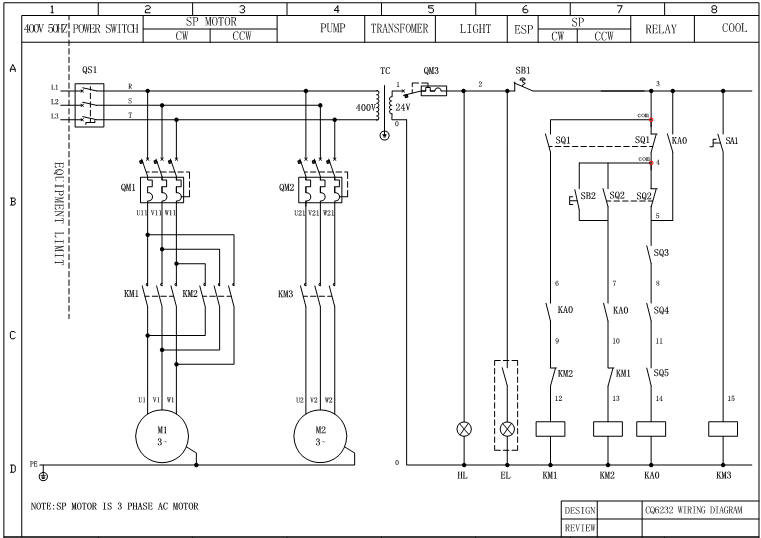


🧑: Can you explain electric circuit?
🤖: An electric circuit, as described in the context of the manual, refers to the system of electrical connections that power and control machines and accessories. Specifically, the manual provides details on the electric circuit for a 3-phase AC motor and its associated components, which are essential for ensuring proper electrical functionality and safety during operation.

Key components and controls of the electric circuit include:

1. **Main Switch**: Located on the left side of the electric panel, equipped with a safety key to prevent unauthorized use. It is crucial for powering the machine.

2. **Electrical and Control Panel**: This panel includes various buttons and lights that are essential for operating the machine:
   - **Red Mushroom Button**: An emergency stop button.
   - **White Warning Light**: Indicates the presence of voltage in the system.
   - **Black Selector**: Used for selecting the coolant pump.
   - **Green Button**: Used fo

In [308]:
ask("Can you explain electric circuit?")

In [379]:
from collections import Counter
markdown_count = sum(1 for m in meta if m.get("path", "").endswith(".md"))
print(f"📄 Total Markdown files upserted: {markdown_count}")


📄 Total Markdown files upserted: 0



🖼️  You can refer to the following diagram:
• image → data/images/doc2_p013_img02_515.png (page 13.0)


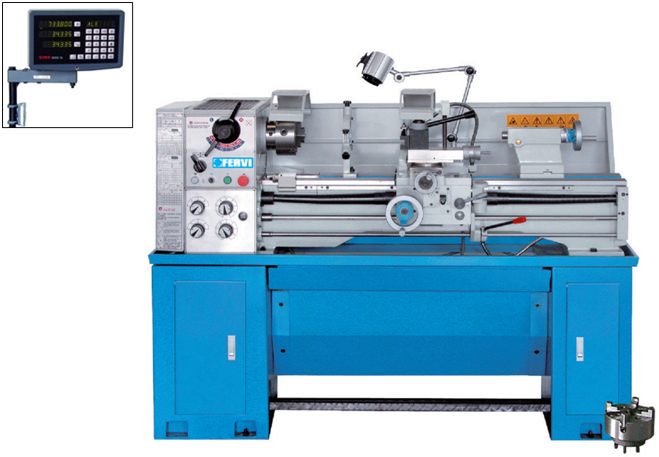


🧑: Show me the lathe diagram
🤖: The diagram of the lathe you are referring to is likely found in the section titled "MACHINES AND ACCESSORIES" on page 12. This section includes a description of the main parts of the gear head lathe, specifically for models Art. T999/230V and T999/400V. The figure illustrates key components essential for operation and maintenance. Here is a structured list of the main parts as described:

1. Brake
2. Carriage handwheel
3. [Component not listed]
4. [Component not listed]
5. [Component not listed]
6. [Component not listed]
7. [Component not listed]
8. [Component not listed]
9. Protective device
10. [Component not listed]
11. [Component not listed]
12. [Component not listed]
13. [Component not listed]
14. [Component not listed]
15. [Component not listed]
16. [Component not listed]
17. Tailstock handwheel
18. [Component not listed]
19. [Component not listed]
20. [Component not listed]
21. [Component not listed]
22. [Component not listed]
23. [Component not

In [438]:
ask("Show me the lathe diagram")

In [439]:
from IPython.display import display, Image as IPImage
from pathlib import Path

def debug_caption_context(img_path: Path, heading: str = "", fig_title: str = "", snippet: str = "", show_image=True):
    """
    Print the GPT prompt content used during image captioning.
    Shows prompt, image file path, and optional image preview.
    """

    def build_caption_prompt(heading: str, fig_title: str) -> str:
        return f"""You are captioning an illustration from a machine user manual.

• Section heading: {heading or 'N/A'}
• Figure title  : {fig_title or 'N/A'}

TASK:
1. Write ONE sentence (≤35 words) saying what the figure shows **and** why it matters here.
2. Start the sentence with “[{fig_title or 'Figure'}]”.
Be literal, concise, no assumptions."""

    prompt_text = build_caption_prompt(heading, fig_title)

    print("\n🧾 GPT Caption Prompt:")
    print("=" * 60)
    print(prompt_text)

    print("\n📍 Image File Path:")
    print(img_path.resolve())

    print("\n🧩 Text Snippet Sent Alongside:")
    print("=" * 60)
    print(snippet.strip() or "[None]")

    if show_image and img_path.exists():
        try:
            display(IPImage(filename=str(img_path), width=400))
        except Exception as e:
            print(f"[!] Could not display image: {e}")


In [445]:
from pathlib import Path

def print_caption_inputs(items):
    for item in items:
        if item.get("type") in {"image", "page"}:
            path = Path(item["path"])
            heading = item.get("section", "")
            fig_title = item.get("figure_title", "")
            snippet = item.get("text", "")[:400]  # optional: truncate

            prompt = f"""You are captioning an illustration from a machine user manual.

• Section heading: {heading or 'N/A'}
• Figure title  : {fig_title or 'N/A'}

TASK:
1. Write ONE sentence (≤35 words) saying what the figure shows **and** why it matters here.
2. Start the sentence with “[{fig_title or 'Figure'}]”.
Be literal, concise, no assumptions."""

            print("\n" + "="*80)
            print(f"📍 Image: {path.name}")
            print("🧾 Prompt:\n" + prompt)
            print("🧩 Snippet:\n" + snippet.strip())


In [446]:
print_caption_inputs(items)



📍 Image: doc2_p001_img00_515.png
🧾 Prompt:
You are captioning an illustration from a machine user manual.

• Section heading: m
• Figure title  : N/A

TASK:
1. Write ONE sentence (≤35 words) saying what the figure shows **and** why it matters here.
2. Start the sentence with “[Figure]”.
Be literal, concise, no assumptions.
🧩 Snippet:
Section header: m
Matter in that section: OPERATION AND MAINTENANCE MANUAL Bench Lathe Art. T999/230V – T999/230V3A Art. T999/400V - T999/400V3Afervi.com TRANSLATION OF THE ORIGINAL INSTRUCTIONS
Figure Title: N/A
Description of the image: [Figure] This figure shows a lathe machine with a digital display, highlighting its functionality for precision machining, which is essential for achieving accur

📍 Image: doc2_p001_img01_516.png
🧾 Prompt:
You are captioning an illustration from a machine user manual.

• Section heading: m
• Figure title  : N/A

TASK:
1. Write ONE sentence (≤35 words) saying what the figure shows **and** why it matters here.
2. Start the